In [1]:
import numpy
import time
import pickle
import operator
from __future__ import print_function

### Load the files

In [2]:

def load_file(filepath):
    """Reads a file into a list of phrases. Each phrase in the file must be separated with a new line character '\n' 
    Args:
        filepath (str): the relevant filepath of the file
    Returns:
        phrases (list(str)): A list with all the phrases 
    """
    with open(filepath, 'r') as f:
        phrases = f.readlines()
    return phrases

src_file = load_file('data/file.de')
trg_file = load_file('data/file.en')
aligned_file = load_file('data/file.aligned')

### Extract consistent pairs (f,e) along with their frequencies

In [42]:
def extract(trg_start, trg_end, src_start, src_end, alignments, trg_aligned, trg_len):    
    """ Checks if the subphrases of the source and target language are a consisnte pair, 
        assuming that no word in the source language is aligned with a word of the target language  outside the boundaries
    Args:
        trg_start (int): The target subphrase's first word position
        trg_end (int): The target subphrase's last word position
        src_start (int): The source subphrase's first word position
        src_end (int): The source subphrase's last word position
        alignments (list(tuple(int))): The alignment between the 
        trg_aligned (set(str)): A set with all the target language words that are aligned with at least one source word 
        trg_len (int): The number of words of the target language phrase
        
    Returns:
        E (list(tuple(str))): A list with all of the extracted phrase pairs (f,e). This is the base (f,e) specified by the arguement and pairs that have a words appended on 'e' that are unaligned 
        A (list(list(tuple(int)))): A list with the alignment of the respective pair at E (A[i] has the alignments of E[i]) 

    """
    if trg_end < 0 :
        return [], []
    
    A = []
    
    a = []
    
    for trg_word, src_word  in alignments:
        if trg_start <= trg_word <= trg_end:
            
            if (src_word < src_start or src_word > src_end):  
                return [], []
            else:
                
                a.append( (trg_word - trg_start, src_word - src_start) )

    E = []
    trg_s = trg_start
    
    while True:
        trg_e = trg_end
        while True:
            E.append( (" ".join(trg_words[trg_s:trg_e+1]) , " ".join(src_words[src_start:src_end+1]) ))
            
            A.append(a)
             
            trg_e += 1
            
            if trg_e in trg_aligned or trg_e == len(trg_words):
                break 

        trg_s -= 1
        
        if trg_s in trg_aligned or trg_s < 0:
            break
            
        # if an unaligned word was added at the beginning, increase the alignments positions by 1 
       
        a = [(i[0]+1,i[1]) for i in a]
        
    return E, A


def extract_phrases(src_words, trg_words, alignments, cutoff):
    """
    Args:
        src_words (list(str)):
        trg_words (list(str)):
        alignments (list(tuple(int))):
        cutoff (int): 
        
    Returns:
        extracted_phrases (list(tuple(str))):
        extracted_alignments (list(tuple(int))):
    """
    
    if cutoff == -1:
        cutoff = len(src_words)
        
        
    trg_aligned = set()
    for (trg,_) in alignments:
        trg_aligned.add(trg)
    
    
    extracted_phrases = []
    extracted_alignments = []
    # for every possible 
    for src_start in range(len(src_words)):
        for src_end in range(src_start, min(src_start + cutoff, len(src_words))):

            #Find the min and max position of the target words that the source phrase is aligned to
            trg_start = len(trg_words) - 1
            trg_end = - 1
            for  (trg,src) in alignments: 
                if src_start <= src <= src_end:
                    trg_start = min(trg, trg_start)
                    trg_end = max(trg, trg_end)
                    
            
            if(trg_end - trg_start > cutoff - 1):
                continue

            phrase_pairs, A = extract(trg_start, trg_end, src_start, src_end, alignments, trg_aligned, len(trg_words))
            
            if (phrase_pairs):
                extracted_phrases.extend(phrase_pairs)
                for a in A:
                    extracted_alignments.append(a);
            
    return extracted_phrases, extracted_alignments

In [43]:
def add_freq_dict(dictionary, item):
    """Increases the frequency of an phrase/item in the dictionary by 1, or adds it with a frequency of 1 if it doesn't exist yet
    Args:
        dictionary (dict): a dictionary that holds the frequency of an a phrase (item)
        item (str): a string whose frequency will be increased
    """
    if item in dictionary:
        dictionary[item] += 1
    else:
        dictionary[item] = 1

        
# A dictionary that maps a source phrase f to its frequency freq(f)
freq_src = dict() #

# A dictionary that maps a target phrase e to its frequency freq(e)
freq_trg = dict() #

# A dictionary f(e,f)->[freq(e,f), A] which initially maps a consistent pair (e,f) to its frequency freq(e,f) and a set A with all existing alignments between them.
# Additional information is added consequently to the value list, like p(f|e), p(e|f), l(f|e) and l(e|f)
freq_pairs = dict() 

start_time = time.time()
    
for i in range(len(src_file)):
    src_words = src_file[i].split()
    trg_words = trg_file[i].split()        
    alignments = [[int(a) for a in alignment.split('-')] for alignment in aligned_file[i].split()] #convert to list of int pairs
    alignments = [(al[1], al[0]) for al in alignments] #reverse their order so that they are (trg,src) instead of (src,trg)
    
    #Extract all the consistent phrase pairs with their alignments
    phrase_pairs, extracted_alignments = extract_phrases(src_words, trg_words, alignments, 5)
     
    #Add the phrases to the dictionaries
    for j, pair in enumerate(phrase_pairs):
        
        a = extracted_alignments[j]
       
        # If the pair (f,e) already exists, then increase its frequency and add the new alignment
        if pair in freq_pairs:
            freq_pairs[pair][0] += 1;
            freq_pairs[pair][1].add(tuple(a));
        else:
             freq_pairs[pair] = [1, set([tuple(a)])]
        
        add_freq_dict(freq_trg, pair[0]) #increase the frequency of the source phrase f
        add_freq_dict(freq_src, pair[1]) #increase the frequency of the target phrase e
        
    #show real time progress
    if (i % (len(src_file) / 100) == 0):
        print(' \r%d / %d (%ds)'%(i+1,len(src_file), time.time() - start_time), end = '')

print()
print('Done!!!')
print('Total duration: %ds'%(time.time() - start_time))

print("#unique en phrases: %d"%(len(freq_trg)))
print("#unique de phrases: %d"%(len(freq_src)))
print("#unique (en,de) phrases: %d"%(len(freq_pairs)))

49501 / 50000 (56s)                                                                                               
Done!!!
Total duration: 56s
#unique en phrases: 1363321
#unique de phrases: 1264713
#unique (en,de) phrases: 2691953


## Calculate p(e|f) and p(f|e)

In [91]:
#calculates the probabilities p(e|f) and p(f|e) for every (f,e) pair in freq_pairs and appends it to the end of freq_pairs(f,e)
for trg_src_pair, value in freq_pairs.iteritems():
    freq = value[0]
    
    p_src_trg = 1.0 * freq / freq_trg[trg_src_pair[0]]
    p_trg_src = 1.0 * freq / freq_src[trg_src_pair[1]]
    
    freq_pairs[trg_src_pair] = [freq, value[1], p_src_trg, p_trg_src]
    

## Calculate lexical translation probabilities (KMO approach)

In [93]:
def KMO(src_words, trg_words, possible_alignments, w_trg_src):
    """ Returns the lexical weight l(e|f) between a phrase pair (e,f) using the KMO approach
    Args:
        src_words (list(str)): the words of the f phrase
        trg_words (list(str)): the words of the e phrase
        possible_alignments (list(list(tuple(int)): all of the possible alignments 'a' between these 2 phrases
        w_trg_src (dict(tuple(str))): A dictionary with the word translation probabilities
    Return:
        lex (float): l(e|f)
    """
    lex = -1
    
    for a in possible_alignments:
    
        #each position holds for a word 'e' all of the w(e|f) with its aligned words 'f'
        mat = len(trg_words) * [None] 

        for (trg_pos, src_pos) in a:

            src_word = src_words[src_pos]
            trg_word = trg_words[trg_pos]

            if mat[trg_pos] is None:
                mat[trg_pos] = []

            
            # if these two words are paired in the word translation probabilities map, then take the probability
            
            if (trg_word, src_word) in w_trg_src:
                w = w_trg_src[(trg_word, src_word)] # w(e|f)
                mat[trg_pos].append(w)
                
            # else it is zero
            else:
                mat[trg_pos].append(0)

        #Calculate the mean for each 'e' word
        for i in range(len(mat)):
            # if the e word was unaligned, then it is 1, basically ignoring it
            if mat[i] is None:
                mat[i] = 1
            else:
                mat[i] = numpy.mean(mat[i])
 
    
        lex = max(lex, numpy.product(mat))
    
    return lex;


c = 1
start_time = time.time()

for trg_src_pair, value in freq_pairs.iteritems():
    
    #calculate p(e|f)
    trg_words = trg_src_pair[0].split()
    src_words = trg_src_pair[1].split()
    possible_alignments = value[1]
    w_trg_src = {}''
    for a in possible_alignments:
        for (trg_pos, src_pos) in a:
            pair = (trg_words[trg_pos], src_words[src_pos])
            if pair in freq_pairs:
                w_trg_src[pair] = freq_pairs[pair][3]
                
                
    lex_trg_src = KMO(src_words, trg_words, possible_alignments, w_trg_src);
    
    #calcuate p(f|e) - Reverse the source and target language
    trg_words , src_words = src_words , trg_words

    #reverse the alignments from (trg,src) to (src,trg)
    possible_alignments2 = set()
    for a in possible_alignments:
        a2 = tuple([(al[1], al[0]) for al in a])
        possible_alignments2.add(a2)
        
    w_src_trg = {}
    for a in possible_alignments2:
        for (trg_pos, src_pos) in a:
            inv_pair = (src_words[src_pos], trg_words[trg_pos])
            if inv_pair in freq_pairs:
                w_src_trg[(inv_pair[1], inv_pair[0])] = freq_pairs[inv_pair][2]
    
    lex_src_trg = KMO(src_words, trg_words, possible_alignments2, w_src_trg)
    
    
    
    freq_pairs[trg_src_pair].append(lex_src_trg)
    freq_pairs[trg_src_pair].append(lex_trg_src)
        
    if  c % (len(freq_pairs) / 100) == 0: 
        print(' \r%d / %d (%d%%) (%ds)'%(c,len(freq_pairs), 100 * c / len(freq_pairs),time.time() - start_time), end = '')
    c +=1
        


print('\nDone!!')
    

2691900 / 2691953 (99%) (216s)                                                                                              
Done!!


# Print the outputs

In [74]:

sorted_pairs = sorted(freq_pairs.keys(), key=operator.itemgetter(1), reverse = False)
output_folder = 'C:/Users/Thanos/Desktop/outputs/'

### Print the first file containg the frequencies:   *f ||| e ||| freq(f) freq(e) freq(f; e)*

In [35]:
c = 0
start_time = time.time();
with open(output_folder + 'output1.txt', 'w') as the_file:

    for pair in sorted_pairs: 
        f = pair[1]
        e = pair[0]
 
        freq_f = freq_src[f]
        freq_e = freq_trg[e]
        freq_fe = freq_pairs[pair][0]
        
        the_file.write('%s ||| %s ||| %d %d %d\n' % (f,e,freq_f, freq_e, freq_fe))

        if  c % (len(freq_pairs) / 100) == 0: 
            print(' \r%d / %d (%d%%) (%ds)'%(c,len(sorted_pairs), 100 * c / len(sorted_pairs),time.time() - start_time), end = '')
        c +=1

print("\nDone!!!")

2691900 / 2691953 (99%) (10s)                                       
Done!!!


### Print the second file containing the probabilities:  * f ||| e ||| p(f|e) p(e|f)*

In [36]:
c = 0
start_time = time.time();
with open(output_folder + 'output2.txt', 'w') as the_file:

    for pair in sorted_pairs: 
        f = pair[1]
        e = pair[0]
 
        p_f_e = freq_pairs[pair][2]
        p_e_f = freq_pairs[pair][3]
        
        the_file.write('%s ||| %s ||| %f %f\n' % (f, e, p_f_e, p_e_f))

        if  c % (len(freq_pairs) / 100) == 0: 
            print(' \r%d / %d (%d%%) (%ds)'%(c,len(sorted_pairs), 100 * c / len(sorted_pairs),time.time() - start_time), end = '')
        c +=1

print("\nDone!!!")

2691900 / 2691953 (99%) (8s)                               
Done!!!


### Print the third file containing the probabilities and the lexical weights:* f ||| e ||| p(f|e) p(e|f) l(f|e) l(e|f)*

In [39]:
c = 0
start_time = time.time();
with open(output_folder + 'output3.txt', 'w') as the_file:

    for pair in sorted_pairs: 
        f = pair[1]
        e = pair[0]
 
        p_f_e = freq_pairs[pair][2]
        p_e_f = freq_pairs[pair][3]
        
        l_f_e = freq_pairs[pair][4]
        l_e_f = freq_pairs[pair][5]
        
        
        the_file.write('%s ||| %s ||| %f %f %f %f\n' % (f, e, p_f_e, p_e_f, l_f_e, l_e_f))

        if  c % (len(freq_pairs) / 100) == 0: 
            print(' \r%d / %d (%d%%) (%ds)'%(c,len(sorted_pairs), 100 * c / len(sorted_pairs),time.time() - start_time), end = '')
        c +=1

print("\nDone!!!")

2691900 / 2691953 (99%) (11s)                                         
Done!!!


### Print the fourth file containing everything:* f ||| e ||| p(f|e) p(e|f) l(f|e) l(e|f) |||  freq(f) freq(e) freq(f; e)**

In [40]:
c = 0
start_time = time.time();

with open(output_folder + 'output_all.txt', 'w') as the_file:
    for pair in sorted_pairs: 
        f = pair[1]
        e = pair[0]
        
        freq_f = freq_src[f]
        freq_e = freq_trg[e]
        freq_fe = freq_pairs[pair][0]
 
        p_f_e = freq_pairs[pair][2]
        p_e_f = freq_pairs[pair][3]
        
        l_f_e = freq_pairs[pair][4]
        l_e_f = freq_pairs[pair][5]
        
        
        the_file.write('%s ||| %s ||| %f %f %f %f ||| %d %d %d \n' % (f, e, p_f_e, p_e_f, l_f_e, l_e_f, freq_f, freq_e, freq_fe))

        if  c % (len(freq_pairs) / 100) == 0: 
            print(' \r%d / %d (%d%%) (%ds)'%(c,len(sorted_pairs), 100 * c / len(sorted_pairs),time.time() - start_time), end = '')
        c +=1

print("\nDone!!!")

2691900 / 2691953 (99%) (16s)                                              
Done!!!


In [2]:
with open("data/complete/freq_pairs", 'rb') as file:
    freq_pairs = pickle.load(file)

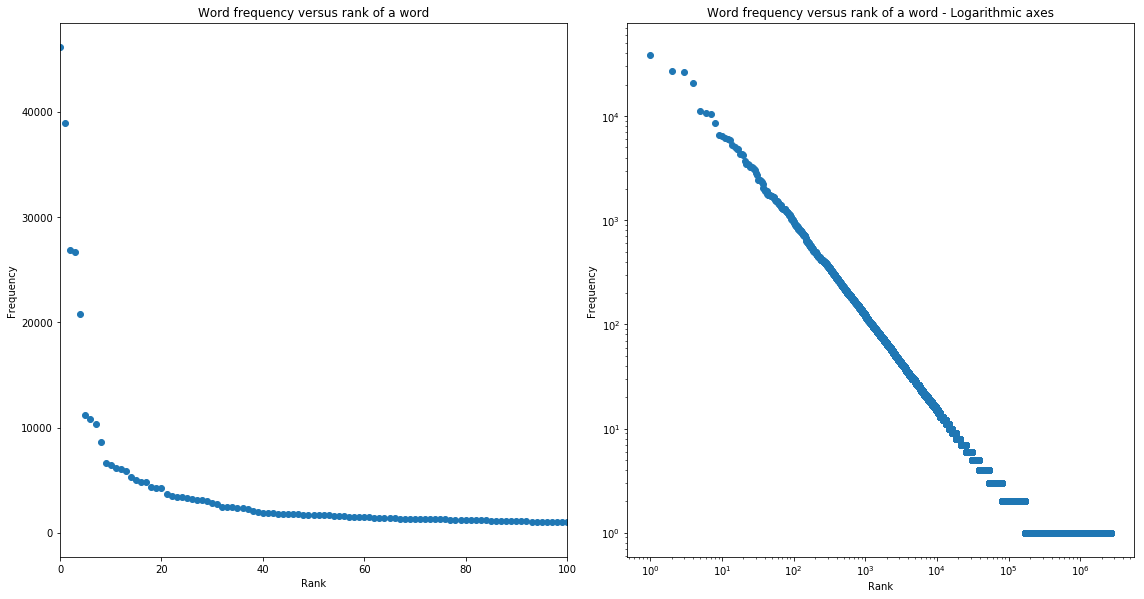

In [3]:
import operator
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

sorted_x = sorted(freq_pairs.items(),  key=lambda e: e[1][0], reverse = True)


# plot word frequency versus rank of a word
fig = plt.figure()
fig.set_figheight(16)
fig.set_figwidth(16)
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

ax1.plot([x[1][0] for x in sorted_x],'o')
ax1.set_xlim(0,100)
ax1.set_title("Word frequency versus rank of a word")
ax1.set_xlabel("Rank")
ax1.set_ylabel("Frequency")





# plot word frequency versus rank of a word using logarithmic axes
ax2.plot([x[1][0] for x in sorted_x],'o')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title("Word frequency versus rank of a word - Logarithmic axes")
ax2.set_xlabel("Rank")
ax2.set_ylabel("Frequency")



plt.tight_layout()
fig = plt.gcf()

# It seems from the plot that the corpus does obey Zipf's law.

